# Feature (Conformational) Selection

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style = 'whitegrid', font_scale = 1.3)

In [2]:
sys.path.append('..')
from modules.plotting_metrics import PlotMetric

In [209]:
# Helper function
%run ./helper_functions_S6.ipynb

### Load the data:

In [210]:
# Dictionary of docking results
# notebook helper_functions does the trick
scores_dic = get_docking_scores_dict()

In [211]:
df_test = scores_dic['CSAR']['Dk_sc']['X']

In [169]:
# Get the correlation matrix
# Pearson 
corr_pear = df_test.corr()
# Spearman 
corr_spear = df_test.corr(method = 'spearman')
# kendall
corr_kendall = df_test.corr(method = 'kendall')

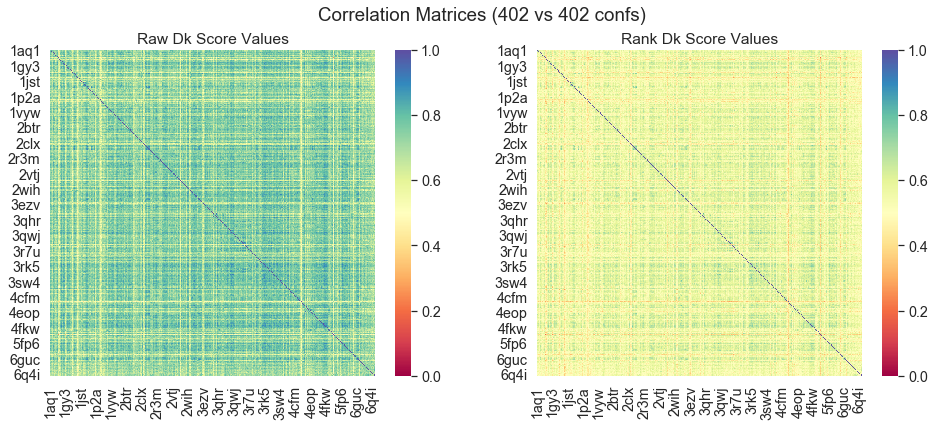

In [170]:
# Plot the correlation matrix using Kendall's Tau and Spearman's Rank Correlations Coef.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(corr_spear, vmin = 0, vmax = 1, cmap = 'Spectral', ax= ax1)\
                                        .set_title('Raw Dk Score Values')
sns.heatmap(corr_kendall, vmin = 0, vmax = 1, cmap = 'Spectral', ax= ax2)\
                                        .set_title('Rank Dk Score Values')
fig.suptitle('Correlation Matrices (402 vs 402 confs)')
plt.show()

In [46]:
# We are going to keep the spearman correaltion matrix usin the ranked values

In [47]:
# Next step, clustering using ward hierarchical clustring

In [303]:
def correlation(dataset, threshold):
    # Creates a dictionary with feature names and a counter initialized at zero
    counter_of_corrs = {f: 0 for f in dataset.columns}
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr(method='spearman')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold):
                colname_i = corr_matrix.columns[i] # getting the name of column i
                colname_j = corr_matrix.columns[j] # getting the name of column i
                counter_of_corrs[colname_i] += 1
                counter_of_corrs[colname_j] += 1
    # Trasnform the result to a series
    counter_of_corrs = pd.Series(counter_of_corrs)
    return(counter_of_corrs)

def drop_features(dataset, thr, min_thr, step, list_of_droped_features):
    counter_of_corrs = correlation(dataset, thr)
    max_n_correlations = counter_of_corrs.max()
    if max_n_correlations > 0:
        # Get the features with the max value
        features = counter_of_corrs[counter_of_corrs == max_n_correlations]
        features_names = [i for i in features.index]
        print(features_names)
        # Drop one feature ramdomly
        feature_to_drop = np.random.choice(features_names)
        list_of_droped_features.append(feature_to_drop)
        print(feature_to_drop, '->', round(thr, 3))
        new_dataset = dataset.drop([feature_to_drop], axis = 1)
        # Recursively
        drop_features(new_dataset, thr, min_thr, step, list_of_droped_features)
    elif thr >= min_thr:
        #print(thr, min_thr)
        drop_features(dataset, thr - step, min_thr, step, list_of_droped_features)

def features_to_drop(dataset, min_thr, max_thr, step):
    dataset = dataset.copy()
    list_of_droped_features = []
    # User recursion to find
    drop_features(dataset, max_thr, min_thr, step, list_of_droped_features)
    
    return(list_of_droped_features)

In [323]:
df_test[['1aq1', '1pxk', '2duv', '2jgz', '2vu3', '3qwk', '4nj3', '5fp5', '6q4i']].corr().round(3)

,1aq1,1pxk,2duv,2jgz,2vu3,3qwk,4nj3,5fp5,6q4i
1aq1,1.000,0.654,0.638,0.652,0.720,0.713,0.754,0.665,0.673
1pxk,0.654,1.000,0.675,0.569,0.562,0.579,0.700,0.653,0.585
2duv,0.638,0.675,1.000,0.561,0.583,0.613,0.662,0.723,0.600
2jgz,0.652,0.569,0.561,1.000,0.600,0.756,0.517,0.556,0.705
2vu3,0.720,0.562,0.583,0.600,1.000,0.663,0.543,0.593,0.708
3qwk,0.713,0.579,0.613,0.756,0.663,1.000,0.592,0.659,0.665
4nj3,0.754,0.700,0.662,0.517,0.543,0.592,1.000,0.665,0.527
5fp5,0.665,0.653,0.723,0.556,0.593,0.659,0.665,1.000,0.524
6q4i,0.673,0.585,0.600,0.705,0.708,0.665,0.527,0.524,1.000


In [322]:
features_to_drop(df_test[['1aq1', '1pxk', '2duv', '2jgz', '2vu3', 
                          '3qwk', '4nj3', '5fp5', '6q4i']], 0.0, 1, 0.01)

['2duv', '5fp5']
5fp5 -> 0.74
['1aq1', '4nj3']
4nj3 -> 0.73
['2jgz', '3qwk']
3qwk -> 0.72
['1aq1', '2vu3']
2vu3 -> 0.71
['2jgz', '6q4i']
2jgz -> 0.69
['1aq1', '6q4i']
1aq1 -> 0.68
['1pxk', '2duv']
1pxk -> 0.64
['2duv', '6q4i']
2duv -> 0.57


['5fp5', '4nj3', '3qwk', '2vu3', '2jgz', '1aq1', '1pxk', '2duv']

In [276]:
x = correlation(df_test, 0.92)

    
z =[i for i in x[x ==1].index]
z

['2g9x',
 '2iw9',
 '2xnb',
 '3pxf',
 '3pxz',
 '3qtz',
 '3rjc',
 '3rk5',
 '3rk7',
 '3rpv',
 '3s0o',
 '3sw4',
 '3sw7',
 '4ek8',
 '4eoi',
 '4eop']

'3rk7'

In [50]:
from sklearn.cluster import AgglomerativeClustering

In [181]:
hc_corr = AgglomerativeClustering(n_clusters = 3, 
                                  #distance_threshold = 0,
                                  linkage = 'complete')
hc_corr.fit(corr_kendall)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=3)

In [182]:
# Get the labels of a ginven cutoff
k3_labels = hc_corr.labels_

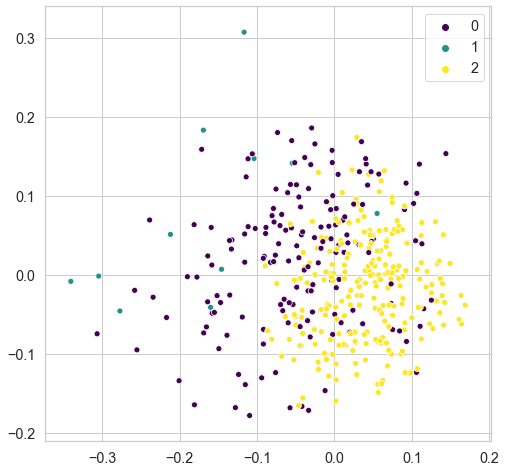

In [183]:
# Convert to a distance matrix
from modules.MDS import cMDS

dist_corr = 1 - corr_kendall

mds_corr = cMDS(dist_corr)

# Plt the cMDS
fig = plt.figure(figsize = (8,8))
sns.scatterplot(x = mds_corr[0][0], y = mds_corr[0][1], hue= k3_labels, palette = 'viridis')

array([0.7413475 , 0.02146025])

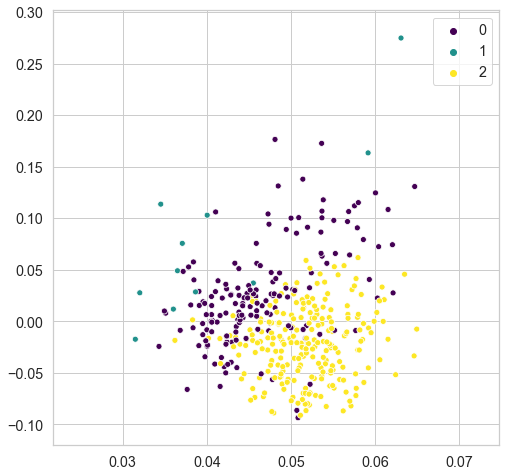

In [185]:
# Performing a PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(PCA(n_components=2))

pipe.fit_transform(df_test)
# Plot
fig = plt.figure(figsize = (8,8))
sns.scatterplot(x = pipe['pca'].components_[0], y = pipe['pca'].components_[1], 
                hue= k3_labels, palette = 'viridis')

pipe['pca'].explained_variance_ratio_

In [172]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

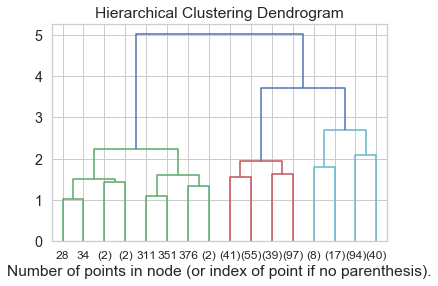

In [173]:
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(hc_corr, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()